### K-means Classification on Iris Data

#### K-means Explanation

K-means clustering is an algorithm that tries to group observations based on similarity.  This algorithm is called an "unsupervised" learning algorithm, because there's no labeled training set that gives predetermined classification labels (or even the "correct" number of labels).  First a number is chosen.  This is the number of clusters the data will be grouped into.  Once this is done, the algorithm iterates over two steps repeatedly.  1. Clusters are grouped around a centroid. 2. Centroids are moved to reduce distance between an given point and its nearest centroid.

These two steps are repeated until the "clusters" stop changing (i.e. until the data have converged to their most appropriate clusters).

#### Implementation

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_iris, load_breast_cancer

%matplotlib inline

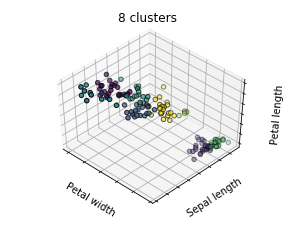

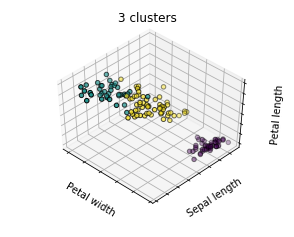

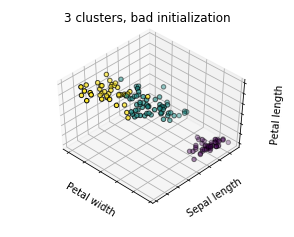

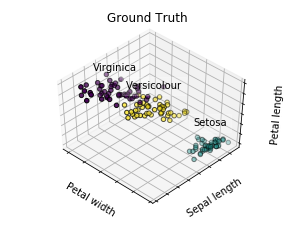

In [4]:
np.random.seed(5)

iris = load_iris()
X = iris.data
y = iris.target

estimators = [('k_means_iris_8', KMeans(n_clusters=8)),
              ('k_means_iris_3', KMeans(n_clusters=3)),
              ('k_means_iris_bad_init', KMeans(n_clusters=3, n_init=1,
                                               init='random'))]

fignum = 1
titles = ['8 clusters', '3 clusters', '3 clusters, bad initialization']
for name, est in estimators:
    fig = plt.figure(fignum, figsize=(4, 3))
    ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
    est.fit(X)
    labels = est.labels_

    ax.scatter(X[:, 3], X[:, 0], X[:, 2],
               c=labels.astype(np.float), edgecolor='k')

    ax.w_xaxis.set_ticklabels([])
    ax.w_yaxis.set_ticklabels([])
    ax.w_zaxis.set_ticklabels([])
    ax.set_xlabel('Petal width')
    ax.set_ylabel('Sepal length')
    ax.set_zlabel('Petal length')
    ax.set_title(titles[fignum - 1])
    ax.dist = 12
    fignum = fignum + 1

fig = plt.figure(fignum, figsize=(4, 3))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

for name, label in [('Setosa', 0),
                    ('Versicolour', 1),
                    ('Virginica', 2)]:
    ax.text3D(X[y == label, 3].mean(),
              X[y == label, 0].mean(),
              X[y == label, 2].mean() + 2, name,
              horizontalalignment='center',
              bbox=dict(alpha=.2, edgecolor='w', facecolor='w'))
# Reorder the labels to have colors matching the cluster results
y = np.choose(y, [1, 2, 0]).astype(np.float)
ax.scatter(X[:, 3], X[:, 0], X[:, 2], c=y, edgecolor='k')

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('Petal width')
ax.set_ylabel('Sepal length')
ax.set_zlabel('Petal length')
ax.set_title('Ground Truth')
ax.dist = 12

fig.show()

### Random Forest on Breast Cancer Data

#### Random Forest Explanation

A random forest model is an "ensemble" method, in that it utilizes multiple decision trees and considers the aggregate over the collection of decision trees to make a final decision.

A number of decision trees is selected, and each decision tree is given slightly different training information.  The final answers are unchanged from tree to tree, but different features are emphasized to a different degree (i.e. different things are given different weights in each tree).

Then, an input is given to each decision tree, and the final classification assigned to the input is the classification given by the majority of the trees in the forest.

#### Implementation

In [13]:
class FixedFeatureRFC:
    def __init__(self, n_estimators=10, random_state=None):
        self.n_estimators = n_estimators

        if random_state is None:
            self.random_state = np.random.RandomState()

    def fit(self, X, y, feats_fixed=None, max_features=None, bootstrap_frac=0.8):
        """
        feats_fixed: indices of features (columns of X) to be 
                     always used to train each estimator

        max_features: number of features that each estimator will use,
                      including the fixed features.

        bootstrap_frac: size of bootstrap sample that each estimator will use.
        """
        self.estimators = []
        self.feats_used = []
        self.n_classes  = np.unique(y).shape[0]

        if feats_fixed is None:
            feats_fixed = []
        if max_features is None:
            max_features = X.shape[1]

        n_samples = X.shape[0]
        n_bs = int(bootstrap_frac*n_samples)

        feats_fixed = list(feats_fixed)
        feats_all   = range(X.shape[1])

        random_choice_size = max_features - len(feats_fixed)

        feats_choosable = set(feats_all).difference(set(feats_fixed))
        feats_choosable = np.array(list(feats_choosable))

        for i in range(self.n_estimators):
            chosen = self.random_state.choice(feats_choosable,
                                              size=random_choice_size,
                                              replace=False)
            feats = feats_fixed + list(chosen)
            self.feats_used.append(feats)

            bs_sample = self.random_state.choice(n_samples,
                                                 size=n_bs,
                                                 replace=True)

            dtc = DecisionTreeClassifier(random_state=self.random_state)
            dtc.fit(X[bs_sample][:,feats], y[bs_sample])
            self.estimators.append(dtc)

    def predict_proba(self, X):
        out = np.zeros((X.shape[0], self.n_classes))
        for i in range(self.n_estimators):
            out += self.estimators[i].predict_proba(X[:,self.feats_used[i]])
        return out / self.n_estimators

    def predict(self, X):
        return self.predict_proba(X).argmax(axis=1)

    def score(self, X, y):
        return (self.predict(X) == y).mean() 

In [14]:
rs = np.random.RandomState(1234)
BC = load_breast_cancer()
X,y = BC.data, BC.target
train = rs.rand(X.shape[0]) < 0.8

print "n_features =", X.shape[1]

fixed = [0,4,21]
maxf  = 10

ffrfc = FixedFeatureRFC(n_estimators=1000)
ffrfc.fit(X[train], y[train], feats_fixed=fixed, max_features=maxf)

for feats in ffrfc.feats_used:
    assert len(feats) == maxf
    for f in fixed:
        assert f in feats

print ffrfc.score(X[~train], y[~train])

n_features = 30
0.983739837398


#### How is Random Forest different from normal Regression?

Random Forest models can be used for regression tasks (These are called Regression Forests).  In short, the model is still breaking up the output space into different classifications, but this is done is a way such that the decision boundary follows the real-valued data points.  In this way, real-valued predictions can be given by returning values from the decision boundary created by the model.

This achieves the same effect as normal regression, but normal regression takes a much more direct approach to defining the prediction function.